In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
#plt.rcParams.update({   "text.usetex": True,})
import scipy.interpolate

# Metode  1 - fra den første artikel

ligninger 

for $\delta_{cdm}$

$\dot{\delta}_{cdm} = - \theta_{cdm}$

$\dot{\theta}_{cdm} = - \mathcal{H}a\theta_{cdm} - \frac{3}{2}\frac{H_0 ^2 \Omega_M}{a} \delta_{cdm}$

baseret på https://arxiv.org/abs/1602.05933 med e ekstra faktor a på $\mathcal{H}$ i $\dot{\theta}_{cdm}$

ved neutrinoer er $\dot{\delta}$ den samme.

$\dot{\theta}_{\nu}   =  -\mathcal{H}a\theta_{\nu} - \frac{3}{2}\frac{H_0 ^2 \Omega_M}{a} \delta_{cdm} + k^2  cs^2 \delta_{\nu}$


In [2]:

def simuler(mv_test, # eV
            kvec,
           x1,k_ind1,
           x2,k_ind2
           ):
    Omega_M = 0.3
    Omega_R = 7e-5
    Omega_lambda = 1 - Omega_M - Omega_R
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    H0 = 67 / (3*1e5) # i 1/Mpc

    cosmo_dict ={'H0':70,  'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                }

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()

    pts = cosmo.get_perturbations()['scalar']
    #print(bg.keys())
    z = bg["z"]
    a = 1/(z+1)
    aend = a[-1]
    a0 = a[0]

    mv = mv_test * 1e-6

    k1 = kvec[k_ind1]
    T_ini1 = x1 / k1

    k2 = kvec[k_ind2]
    T_ini2 = x2 / k2

    # cs front faktoren
    factor = 2.68


    # udregner Hubbleparameteren

    def H(a):
        return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

    # udregnger tau 

    def tau_cal(a,y):
        # Vores "tids"-værdi i denne differentialligning er a
        tau = y[0]
        d_tau = 1 / (a ** 2 * H(a))
        return np.array(d_tau)

    # temperatur

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed

    def cs(a,mv,factor):
        return factor * Tv(a) / mv

    # udregn a
    def a_solve(tau,y):
        a = y[0]
        a_dt = a * a * H(a)
        return [a_dt]

    tau_init =   (1/H0) * (Omega_R ** (-0.5)) * a0


    sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau_init])
    tau = sol_tau.y[0]

    sol_a = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
    a_tau = sol_a.t
    a = sol_a.y[0]

    a_interp = scipy.interpolate.interp1d(a_tau,a)

    # sammenlignings data fra Class

    
    if k1 == k2 :
        # 1
        delta_class1 = delta_class2 =  pts[k_ind1]["delta_cdm"]
        theta_class1 = theta_class2 = pts[k_ind1]["theta_cdm"]
        tau_class1 = tau_class2 = pts[k_ind1]["tau [Mpc]"]
        delta_neutrino_class1 = delta_neutrino_class2 = pts[k_ind1]["delta_ncdm[0]"]
        theta_neutrino_class1 = theta_neutrino_class2 = pts[k_ind1]["theta_ncdm[0]"]
        a_class1 = a_class2 = pts[k_ind1]["a"]
    else:
        # 1
        delta_class1 = pts[k_ind1]["delta_cdm"]
        theta_class1 = pts[k_ind1]["theta_cdm"]
        tau_class1 = pts[k_ind1]["tau [Mpc]"]
        delta_neutrino_class1 = pts[k_ind1]["delta_ncdm[0]"]
        theta_neutrino_class1 = pts[k_ind1]["theta_ncdm[0]"]
        a_class1 = pts[k_ind1]["a"]
        # 2
        delta_class2 = pts[k_ind2]["delta_cdm"]
        theta_class2 = pts[k_ind2]["theta_cdm"]
        tau_class2 = pts[k_ind2]["tau [Mpc]"]
        delta_neutrino_class2 = pts[k_ind2]["delta_ncdm[0]"]
        theta_neutrino_class2 = pts[k_ind2]["theta_ncdm[0]"]
        a_class2 = pts[k_ind2]["a"]
    if T_ini1 == T_ini2 and k_ind1 == k_ind2:

        # 1
        delta_init1 = delta_init2=scipy.interpolate.interp1d(tau_class1,delta_class1)(T_ini1)
        theta_init1 =theta_init2= scipy.interpolate.interp1d(tau_class1,theta_class1)(T_ini1)
        delta_neutrino_init1=delta_neutrino_init2 = scipy.interpolate.interp1d(tau_class1,delta_neutrino_class1)(T_ini1)
        theta_neutrino_init1=theta_neutrino_init2 = scipy.interpolate.interp1d(tau_class1,theta_neutrino_class1)(T_ini1)
        t_span1=t_span2 = [T_ini1,tau[-1]]
    else:
        delta_init1 = scipy.interpolate.interp1d(tau_class1,delta_class1)(T_ini1)
        theta_init1 = scipy.interpolate.interp1d(tau_class1,theta_class1)(T_ini1)
        delta_neutrino_init1 = scipy.interpolate.interp1d(tau_class1,delta_neutrino_class1)(T_ini1)
        theta_neutrino_init1 = scipy.interpolate.interp1d(tau_class1,theta_neutrino_class1)(T_ini1)
        t_span1 = [T_ini1,tau[-1]]
        # 2
        delta_init2 = scipy.interpolate.interp1d(tau_class2,delta_class2)(T_ini2)
        theta_init2 = scipy.interpolate.interp1d(tau_class2,theta_class2)(T_ini2)
        delta_neutrino_init2 = scipy.interpolate.interp1d(tau_class2,delta_neutrino_class2)(T_ini2)
        theta_neutrino_init2 = scipy.interpolate.interp1d(tau_class2,theta_neutrino_class2)(T_ini2)
        t_span2 = [T_ini2,tau[-1]]
        

    def cdm_func(τ,y):
        delta = y[0]
        theta = y[1]    
        a = a_interp(τ)
        d_delta   = - theta
        nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
        d_theta   =  - nabla2phi -  H(a) * theta * a
        return [d_delta,d_theta]

    y01 = [delta_init1,theta_init1]
    y02 = [delta_init2,theta_init2]

    sol_cdm1 = sc.solve_ivp(cdm_func, t_span = t_span1, y0 = y01)
    sol_cdm2 = sc.solve_ivp(cdm_func, t_span = t_span2, y0 = y02)

    t_cdm1 = sol_cdm1.t
    t_cdm2 = sol_cdm2.t
    delta_cdm1 = sol_cdm1.y[0]
    delta_cdm2 = sol_cdm2.y[0]


    delta_cdm_interp1 = scipy.interpolate.interp1d(t_cdm1,delta_cdm1)
    delta_cdm_interp2 = scipy.interpolate.interp1d(t_cdm2,delta_cdm2)

    def neu_func(t,y,k,mv,factor,version):
        delta = y[0]
        theta = y[1]    
        a = a_interp(t)
        d_delta   = - theta
        if version == 1:
            delta_cdm = delta_cdm_interp1(t)
        else:
            delta_cdm = delta_cdm_interp2(t)
        d_theta   =  -  H(a) * a * theta - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor)**2 * delta 
        return [d_delta,d_theta]


    y01_neutrino = [delta_neutrino_init1,theta_neutrino_init1]
    y02_neutrino = [delta_neutrino_init2,theta_neutrino_init2]

    sol_neu1 = sc.solve_ivp(neu_func, t_span = t_span1, y0 = y01_neutrino,args=(k1,mv,factor,1))
    sol_neu2 = sc.solve_ivp(neu_func, t_span = t_span2, y0 = y02_neutrino,args=(k2,mv,factor,2))

    # Det vi plotter neutrinoerne med
    t_nue1 = sol_neu1.t
    t_nue2 = sol_neu2.t
    delta_neu1 = sol_neu1.y[0]
    delta_neu2 = sol_neu2.y[0]


    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Figur 1
    ax1.loglog(t_cdm1,-delta_cdm1,label="min cdm")
    ax1.loglog(t_nue1,-delta_neu1,label="min nu")
    ax1.loglog(tau_class1,-delta_class1,label="class cdm")
    ax1.loglog(tau_class1,-delta_neutrino_class1,label="class nu")
    ax1.axvline(T_ini1)
    ax1.set_xlabel("tau")
    ax1.set_title("k=%s X=%s mv=%.4s eV" %(k1,x1,mv*1e6))
    ax1.legend()
    # Figur 2
    ax2.loglog(t_cdm2,-delta_cdm2,label="min cdm")
    ax2.loglog(t_nue2,-delta_neu2,label="min nu")
    ax2.loglog(tau_class2,-delta_class2,label="class cdm")
    ax2.loglog(tau_class2,-delta_neutrino_class2,label="class nu")
    ax2.axvline(T_ini2)
    ax2.set_xlabel("tau")
    ax2.set_title("k=%s X=%s mv=%.4s eV" %(k2,x2,mv*1e6))
    ax2.legend()
    return None


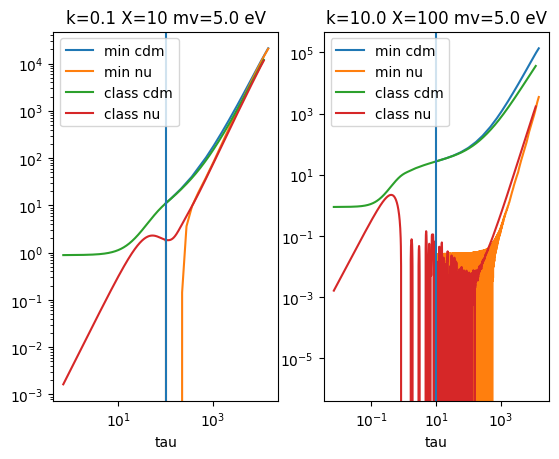

In [3]:
kvec = [1e-1,1e0,1e1]

simuler(5,kvec,10,0,100,-1)